In [1]:
%matplotlib notebook
import tifffile
import matplotlib.pyplot as plt
from scipy.signal import medfilt
import mahotas as mh
from colicoords import iter_subplots
import numpy as np
from symfit import Parameter, Variable, Fit, Model, exp
import os
from addict import Dict

In [2]:
def generate_background(image, median_kernel=11, gaussian_kernel=11, dtype=int):
    assert median_kernel % 2 == 1
    assert image.ndim == 2
    sp_m = medfilt(image, kernel_size=median_kernel)

    #fill corners
    cz = int((median_kernel - 1) / 2)
    sp_m[:cz, :cz] = sp_m[cz, cz]
    sp_m[:cz, -cz:] = sp_m[cz, -cz]
    sp_m[-cz:, -cz:] = sp_m[-cz, -cz]
    sp_m[-cz:, :cz] = sp_m[-cz, cz]

    gf = mh.gaussian_filter(sp_m, gaussian_kernel)

    return gf.astype(dtype)

In [3]:
import symfit
symfit.__version__

'0.5.1'

In [4]:
import colicoords
colicoords.__version__

'0.0.0'

In [5]:
data_dir = r'H:\data\t3ss\20191023_c41_eyfp-escv_escrstu_AHT25' 
#output_dir = r'F:\_processed_big\t3ss\20191002_deltaescv_c41_eyfp-escv_repeat_03'  #moved here
output_dir = r'I:\20191023_c41_eyfp-escv_escrstu_AHT25'  #tempdir, fasterspeed

In [6]:
df_dir = r'H:\data\t3ss\20191009_c41_eyfp-escv_AHT30_agarose_medium_repeats'

In [7]:
dfg100 = tifffile.imread(os.path.join(df_dir, 'Image', 'dark_g100.tif'))
dfg500 = tifffile.imread(os.path.join(df_dir, 'Image', 'dark_g500.tif'))
dfg100.mean() - dfg500.mean()

93.47394943237305

In [8]:
fnames = ['c41_yfp-escv_aht20', 'c41_yfp-escv_aht25', 'c41_yfp-escv_rstu_aht25_iptg0', 'c41_yfp-escv_rstu_aht25_iptg20']

In [9]:
bd = Dict()
for fname in fnames:
    print(fname)
    td = bd[fname]
    td.bf_raw = tifffile.imread(os.path.join(data_dir, fname, '_BF_140_.tif'))
    td.median = np.median(td.bf_raw, axis=0)
    td.bf_flat = (td.bf_raw - dfg100) / (td.median - dfg100)
    np.save(os.path.join(output_dir, fname + '_BF_flat.npy'), td.bf_flat)

c41_yfp-escv_aht20
c41_yfp-escv_aht25
c41_yfp-escv_rstu_aht25_iptg0
c41_yfp-escv_rstu_aht25_iptg20


# c41_yfp-escv_aht20

<IPython.core.display.Javascript object>


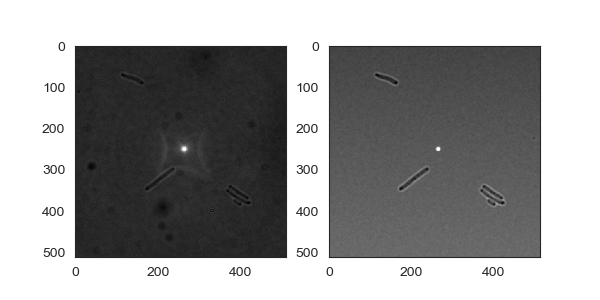

In [12]:
td = bd[fnames[0]]
fig, (ax1, ax2) = iter_subplots(1, 2, figsize=(6, 3))
ax1.iter_imshow(td.bf_raw, cmap='gray')
ax2.iter_imshow(td.bf_flat, cmap='gray')
fig.display()

<IPython.core.display.Javascript object>


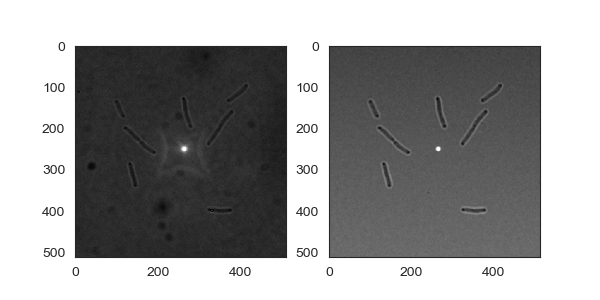

In [13]:
td = bd[fnames[1]]
fig, (ax1, ax2) = iter_subplots(1, 2, figsize=(6, 3))
ax1.iter_imshow(td.bf_raw, cmap='gray')
ax2.iter_imshow(td.bf_flat, cmap='gray')
fig.display()

<IPython.core.display.Javascript object>


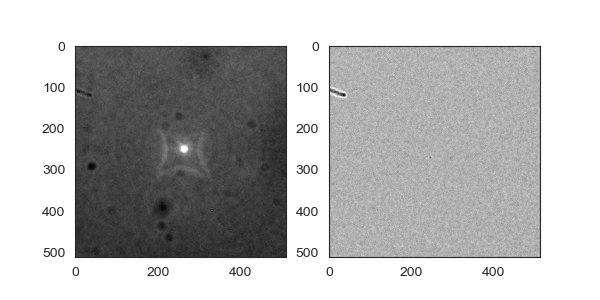

In [14]:
td = bd[fnames[3]]
fig, (ax1, ax2) = iter_subplots(1, 2, figsize=(6, 3))
ax1.iter_imshow(td.bf_raw, cmap='gray')
ax2.iter_imshow(td.bf_flat, cmap='gray')
fig.display()

## Beamprofile

In [41]:
images = ['Image_076.tif', 'Image_075.tif', 'Image_073.tif']
bps = [tifffile.imread(os.path.join(data_dir, 'Image', f)) for f in images]

In [42]:
bp = np.stack(bps)
bp.shape

(3, 512, 512)

<IPython.core.display.Javascript object>


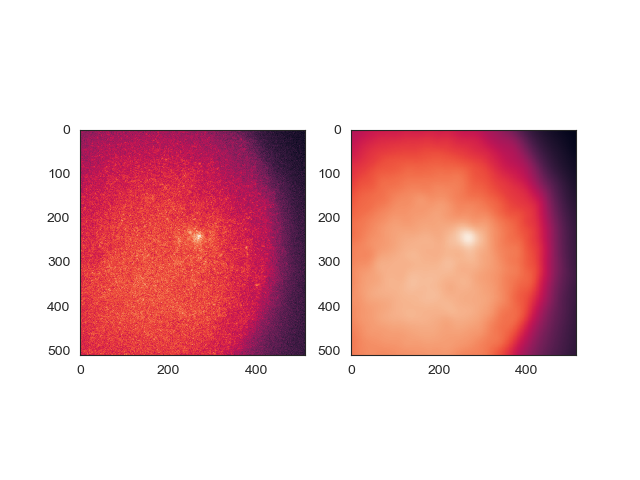

In [43]:
smoothed = generate_background(np.mean(bp, axis=0))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.mean(bp, axis=0))
ax2.imshow(smoothed)

In [15]:
bp_final = smoothed / smoothed.max()

NameError: name 'smoothed' is not defined

In [45]:
tifffile.imsave(os.path.join(output_dir, 'beamprofile.tif'), bp_final)

In [ ]:
cells = ['c41_yfp-escv_aht20', 'c41_yfp-escv_aht25', 'c41_yfp-escv_rstu_aht25_iptg0', 'c41_yfp-escv_rstu_aht25_iptg20']
files = ['514_g100', '514_g500']
dfs = [dfg100, dfg500]

for c in cells:
    for df, f in zip(dfs, files):
        arr = tifffile.imread(os.path.join(data_dir, c, f + '.tif')).astype(float)
        new_arr = arr.reshape(-1, *arr.shape[2:])
        new_arr -= df.mean()
        new_arr /= bp_final
        print(c, f, new_arr.min(), new_arr.max())
        np.save(os.path.join(output_dir, '{}_{}.npy'.format(c, f)), new_arr)

c41_yfp-escv_aht20 514_g100 35.894105498112516 79317.23338378499
c41_yfp-escv_aht20 514_g500 199.55740509706507 124698.13589667232
c41_yfp-escv_aht25 514_g100 -81.44827461500078 83567.54651243478
c41_yfp-escv_aht25 514_g500 83.65321513494754 129385.28317171423
c41_yfp-escv_rstu_aht25_iptg0 514_g100 -35.79753551577556 86882.53188518505
c41_yfp-escv_rstu_aht25_iptg0 514_g500 15.592075704882888 132188.28487773315
c41_yfp-escv_rstu_aht25_iptg20 514_g100 -50.145161245632444 97823.26995018902


In [46]:
c = 'c41_yfp-escv_aht20'
a1 = np.load(os.path.join(output_dir, '{}_{}.npy').format(c, '514_g100'))
a2 = np.load(os.path.join(output_dir, '{}_{}.npy').format(c, '514_g500'))

fig, (ax1, ax2) = iter_subplots(1, 2)
ax1.iter_imshow(a1)
ax2.iter_imshow(a2)
fig.display()

FileNotFoundError: [Errno 2] No such file or directory: 'I:\\20191023_c41_eyfp-escv_escrstu_AHT25\\c41_yfp-escv_aht20_514_g100.npy'

<IPython.core.display.Javascript object>


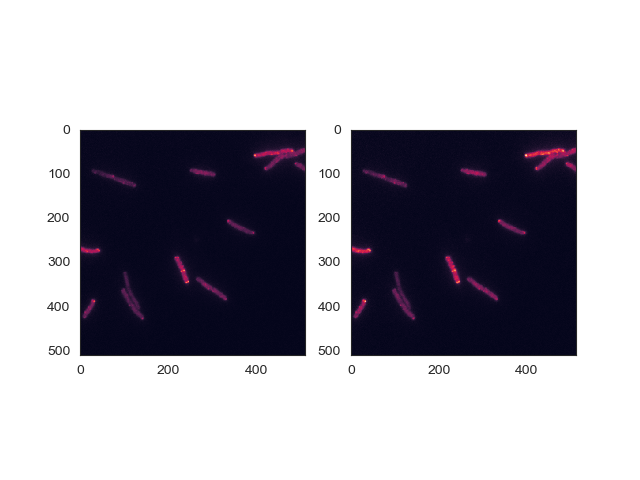

In [60]:
c = 'c41_02'
a1 = np.load(os.path.join(output_dir, '{}_{}.npy').format(c, '514_g100'))
a2 = np.load(os.path.join(output_dir, '{}_{}.npy').format(c, '514_g500'))

fig, (ax1, ax2) = iter_subplots(1, 2)
ax1.iter_imshow(a1)
ax2.iter_imshow(a2)
fig.display()

<IPython.core.display.Javascript object>


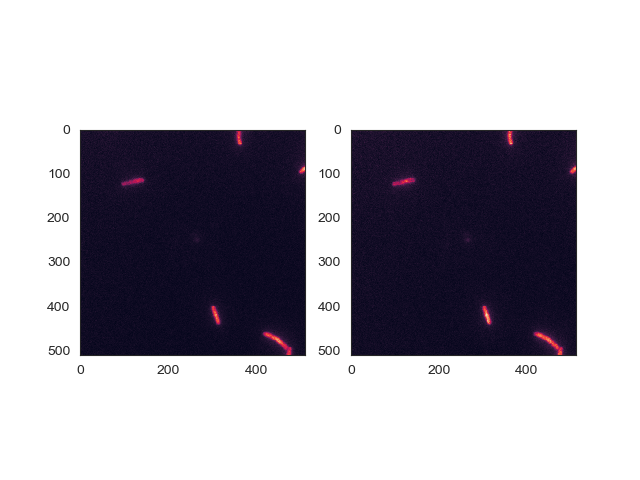

In [61]:
c = 'c41_03'
a1 = np.load(os.path.join(output_dir, '{}_{}.npy').format(c, '514_g100'))
a2 = np.load(os.path.join(output_dir, '{}_{}.npy').format(c, '514_g500'))

fig, (ax1, ax2) = iter_subplots(1, 2)
ax1.iter_imshow(a1)
ax2.iter_imshow(a2)
fig.display()